In [3]:
"""
1- load a file
2- pad the signal (if necessary)
3- extracting log spectrogram from signal
4- normalise spectrogram
5- save the normalised spectrogram

PreprocessingPipeline
"""
import os
import pickle

import librosa
import numpy as np


class Loader:
    """Loader is responsible for loading an audio file."""

    def __init__(self, sample_rate, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.mono = mono

    def load(self, file_path):
        signal = librosa.load(file_path,
                              sr=self.sample_rate,
                              duration=self.duration,
                              mono=self.mono)[0]
        return signal


class Padder:
    """Padder is responsible to apply padding to an array."""

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array


class LogSpectrogramExtractor:
    """LogSpectrogramExtractor extracts log spectrograms (in dB) from a
    time-series signal.
    """

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(signal,
                            n_fft=self.frame_size,
                            hop_length=self.hop_length)[:-1]
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram


class MinMaxNormaliser:
    """MinMaxNormaliser applies min max normalisation to an array."""

    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def normalise(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array


class Saver:
    """saver is responsible to save features, and the min max values."""

    def __init__(self, feature_save_dir, min_max_values_save_dir):
        self.feature_save_dir = feature_save_dir
        self.min_max_values_save_dir = min_max_values_save_dir

    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        np.save(save_path, feature)
        return save_path

    def save_min_max_values(self, min_max_values):
        save_path = os.path.join(self.min_max_values_save_dir,
                                 "min_max_values.pkl")
        self._save(min_max_values, save_path)

    @staticmethod
    def _save(data, save_path):
        with open(save_path, "wb") as f:
            pickle.dump(data, f)

    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path


class PreprocessingPipeline:
    """PreprocessingPipeline processes audio files in a directory, applying
    the following steps to each file:
        1- load a file
        2- pad the signal (if necessary)
        3- extracting log spectrogram from signal
        4- normalise spectrogram
        5- save the normalised spectrogram

    Storing the min max values for all the log spectrograms.
    """

    def __init__(self):
        self.padder = None
        self.extractor = None
        self.normaliser = None
        self.saver = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)

    def process(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            if files[0] != 'min_max_values.pkl':
               for file in files:
                  file_path = os.path.join(root, file)
                  self._process_file(file_path)
                  print(f"Processed file {file_path}")
        self.saver.save_min_max_values(self.min_max_values)

    def _process_file(self, file_path):
        signal = self.loader.load(file_path)
        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.extractor.extract(signal)
        norm_feature = self.normaliser.normalise(feature)
        save_path = self.saver.save_feature(norm_feature, file_path)
        self._store_min_max_value(save_path, feature.min(), feature.max())

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

    def _store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }

if __name__ == "__main__":
    FRAME_SIZE = 512
    HOP_LENGTH = 256
    DURATION = 0.74  # in seconds
    SAMPLE_RATE = 22050
    MONO = True


    SPECTROGRAMS_SAVE_DIR = "datasets/spectrogramsemotional/"
    MIN_MAX_VALUES_SAVE_DIR = "datasets/Knocking Sound Effects With Emotional Intentions/"
    FILES_DIR = "datasets/Knocking Sound Effects With Emotional Intentions/"


    # instantiate all objects
    loader = Loader(SAMPLE_RATE, DURATION, MONO)
    padder = Padder()
    log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
    min_max_normaliser = MinMaxNormaliser(0, 1)
    saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

    preprocessing_pipeline = PreprocessingPipeline()
    preprocessing_pipeline.loader = loader
    preprocessing_pipeline.padder = padder
    preprocessing_pipeline.extractor = log_spectrogram_extractor
    preprocessing_pipeline.normaliser = min_max_normaliser
    preprocessing_pipeline.saver = saver

    preprocessing_pipeline.process(FILES_DIR)

Processed file datasets/Knocking Sound Effects With Emotional Intentions/sadness/sadness_19.wav
Processed file datasets/Knocking Sound Effects With Emotional Intentions/sadness/sadness_7.wav
Processed file datasets/Knocking Sound Effects With Emotional Intentions/sadness/sadness_0.wav
Processed file datasets/Knocking Sound Effects With Emotional Intentions/sadness/sadness_17.wav
Processed file datasets/Knocking Sound Effects With Emotional Intentions/sadness/sadness_4.wav
Processed file datasets/Knocking Sound Effects With Emotional Intentions/sadness/sadness_3.wav
Processed file datasets/Knocking Sound Effects With Emotional Intentions/sadness/sadness_2.wav
Processed file datasets/Knocking Sound Effects With Emotional Intentions/sadness/sadness_8.wav
Processed file datasets/Knocking Sound Effects With Emotional Intentions/sadness/sadness_15.wav
Processed file datasets/Knocking Sound Effects With Emotional Intentions/sadness/sadness_6.wav
Processed file datasets/Knocking Sound Effects 

In [4]:

import librosa.display

import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook

import sys
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:

import glob

FRAME_SIZE = 200
HOP_LENGTH = 100


class Visualization:
    def __init__(self,path,emotions):
        self.path     = path
        self.emotions = emotions


    def amplitude_envelope(self,signal, frame_size, hop_length):
        """Calculate the amplitude envelope of a signal with a given frame size nad hop length."""
        amplitude_envelope = []

        # calculate amplitude envelope for each frame
        for i in range(0, len(signal), hop_length):
            amplitude_envelope_current_frame = max(signal[i:i+frame_size])
            amplitude_envelope.append(amplitude_envelope_current_frame)

        return np.array(amplitude_envelope)

    def get_statistics(self,path,emotions):
        """  this part calculate count of every class and choose random sample for plot  """
        samples          = []
        sample_emotions  = []
        for emotion in emotions:
            file_path = os.path.join(path,emotion+'/*')
            number    = len(glob.glob(file_path))

            index= np.random.randint(0,99)
            fname_ = path + '{}/{}_{}.wav' .format(emotion,emotion,index)
            samples.append(fname_)
            sample_emotions.append(emotion)

            print('Number of {} audio : {}'.format(emotion,number))
        return samples , sample_emotions
    def spec_plot(self,samples, samples_emotions):
        """ this function plot the selected samples """
        j=0
        for i in samples:

            data, sampling_rate = librosa.load(i)
            plt.figure(figsize=(15, 5))
            librosa.display.waveshow(data, sr=sampling_rate)
            ae_= self.amplitude_envelope(data, FRAME_SIZE, HOP_LENGTH)
            frames = range(len(ae_))
            t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
            plt.plot(t, ae_, color="r")
            plt.title('{} Audio sampled at 44100 hrz'.format(samples_emotions[j]))

            ipd.Audio(i)
            plt.figure(figsize=(20, 15))
            plt.subplot(3,1,1)
            mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)
            librosa.display.specshow(mfcc, x_axis='time')
            plt.ylabel('MFCC of {}'.format(samples_emotions[j]))
            plt.colorbar()
            j=j+1





Number of anger audio : 100
Number of happiness audio : 100
Number of fear audio : 100
Number of neutral audio : 100
Number of sadness audio : 100


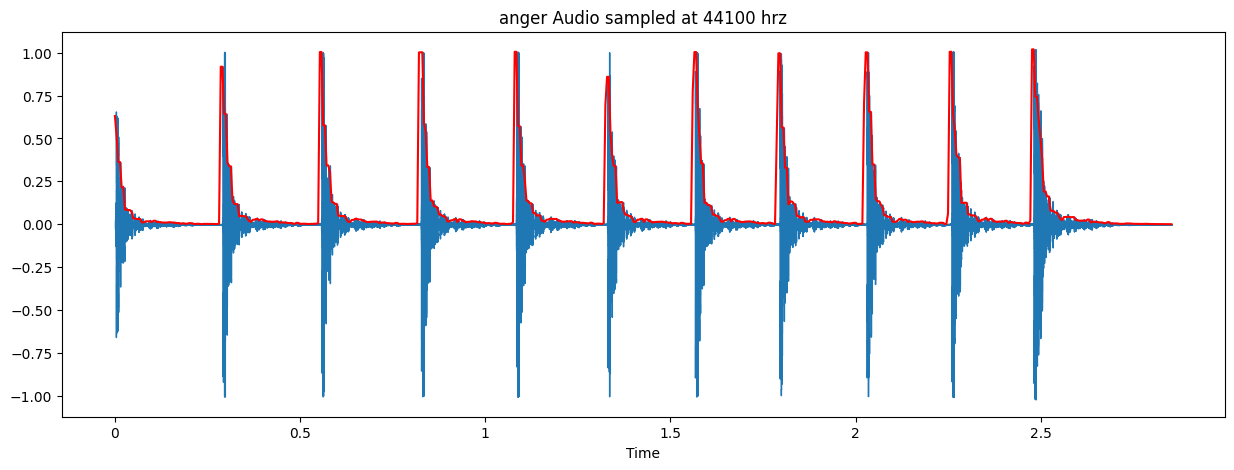

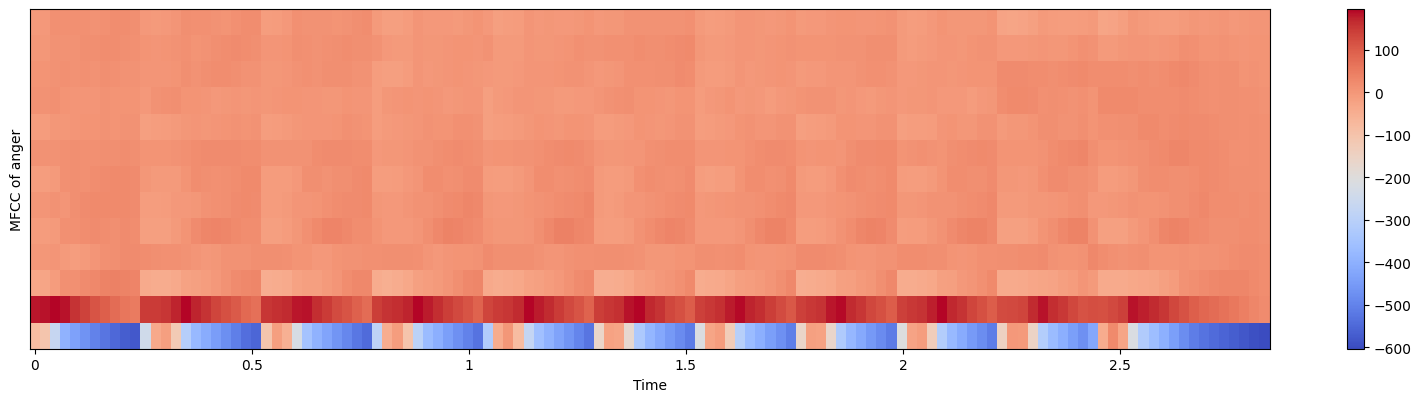

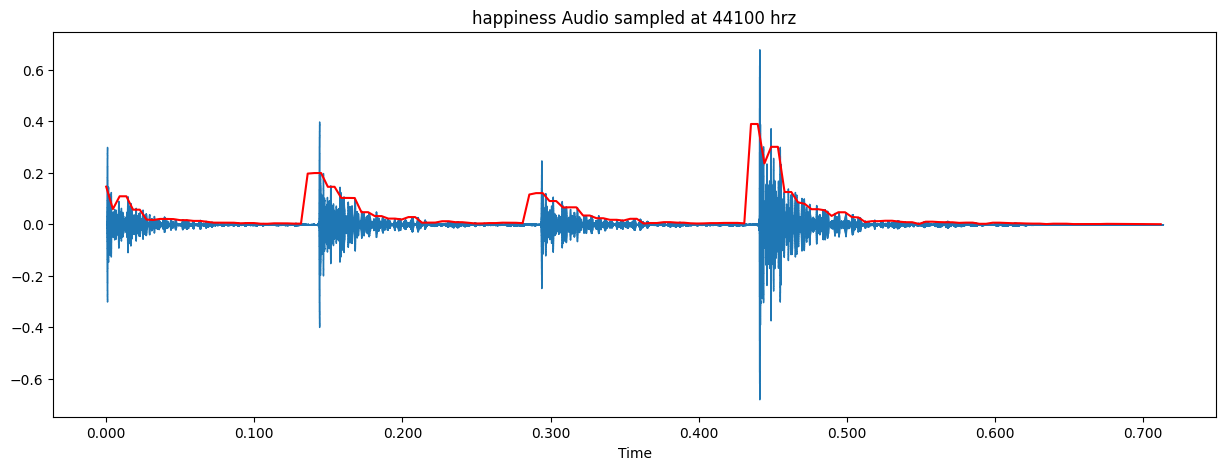

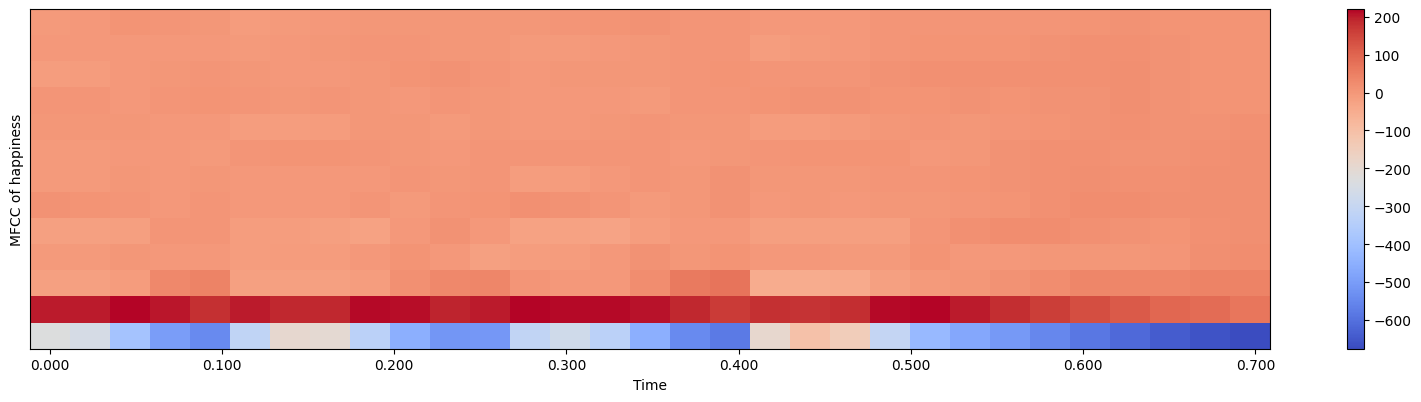

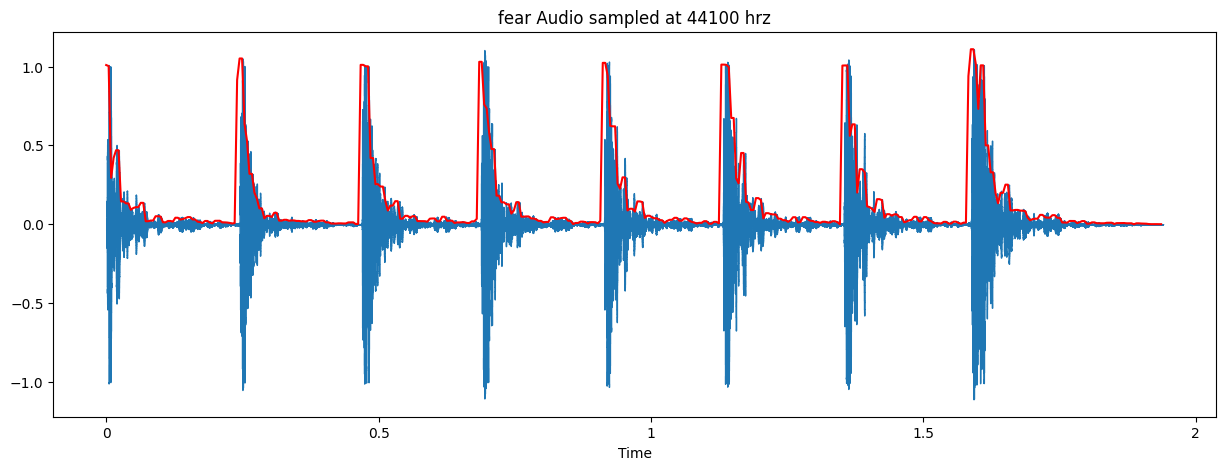

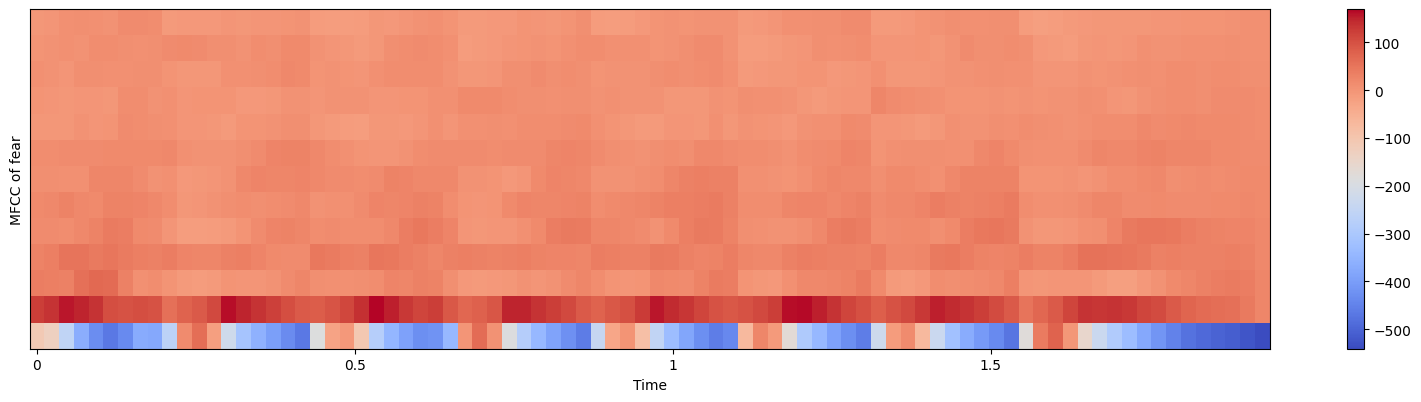

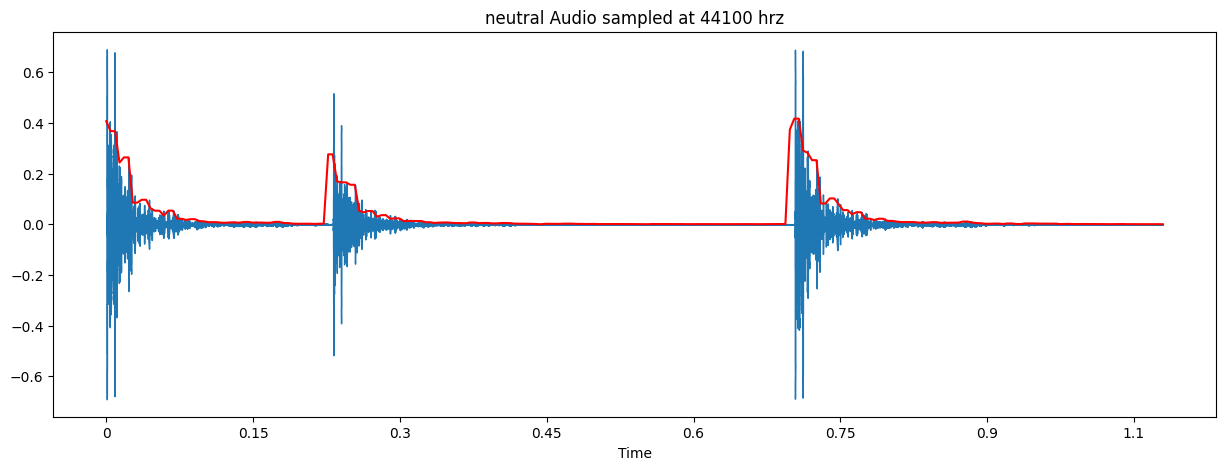

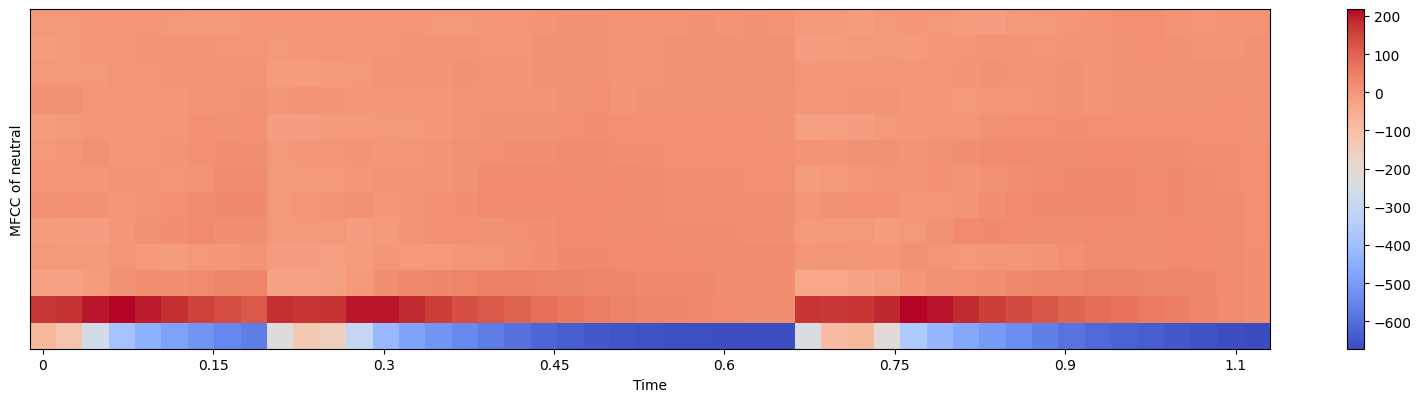

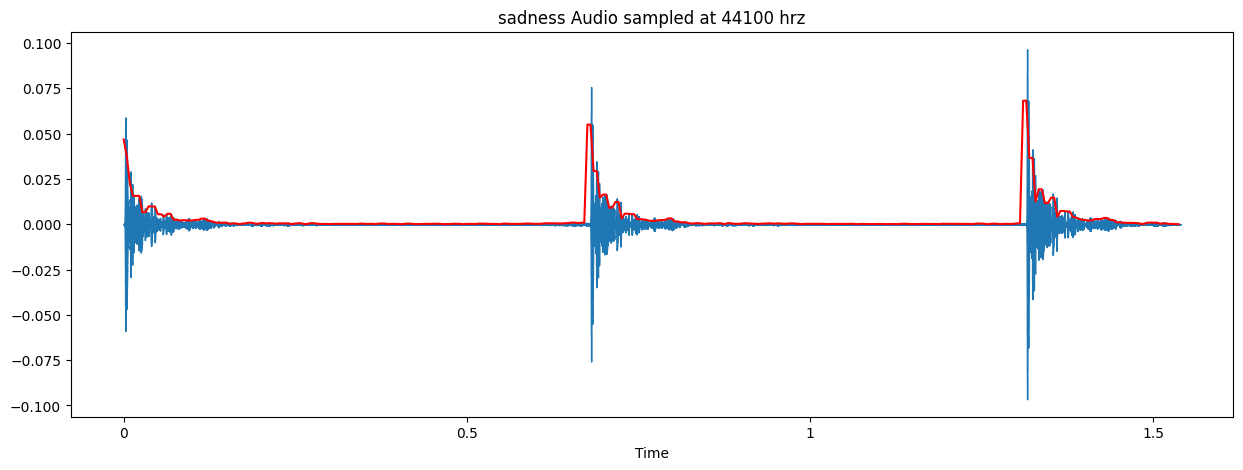

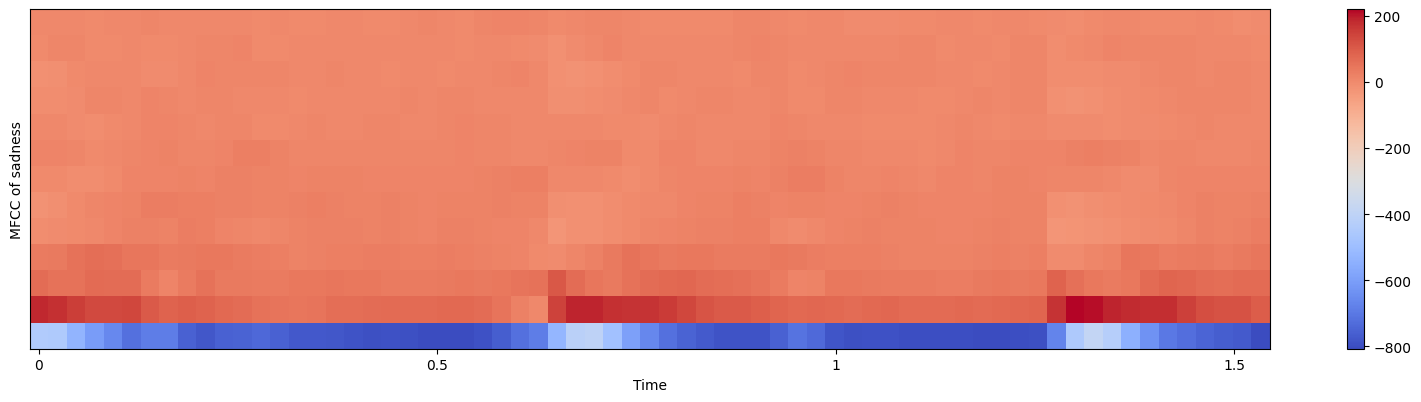

In [6]:
cl=Visualization(path = FILES_DIR , emotions = ['anger','happiness','fear','neutral','sadness'] )
samples,samples_emotions =cl.get_statistics( path = FILES_DIR  , emotions=['anger','happiness','fear','neutral','sadness'])
cl.spec_plot(samples =samples , samples_emotions = samples_emotions)

In [6]:

from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint

import keras.backend as K


In [7]:
pip install  tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.5 MB/s eta 0:00:00


In [8]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [9]:


def get_label(SPECTROGRAMS_SAVE_DIR):
    """ finding labels of all samples """
    labels=[]
    all_data  =[]
    for j in glob.glob(SPECTROGRAMS_SAVE_DIR +'/*'):

         labels.append((j.split('/')[-1]).split('_')[0])
         data=np.load(j)
         all_data.append(data)
    return labels , all_data
def prepare_labels(labels):
    """labels are string and we need to convert them to numbers and after that we transform them to one hot vectors """
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    encoded_labels = le.transform(labels)
    categorical_labels = to_categorical(encoded_labels, num_classes=5)
    return categorical_labels


In [10]:
labels,data = get_label(SPECTROGRAMS_SAVE_DIR)
categorical_labels = prepare_labels(labels)

In [11]:


class CustomertModel:

    def __init__(self, num_classes = 5 , inputs_shape=(256, 64)):
       self.num_classes  = num_classes
       self.inputs_shape = inputs_shape
       self.model =None
       self._built()




    def get_f1(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())
        f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
        return f1_val



    def compile(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        loss      = 'categorical_crossentropy'
        self._built()
        self.model.compile(optimizer=optimizer,
                           loss=loss,
                           metrics =  tfa.metrics.F1Score(num_classes=5,
                                                  average='weighted',
                                                  threshold=0.5) )
    def summary(self):
        self.model.summary()

    def train(self, x_train, labels ,batch_size, validation_split,num_epochs):
        self.model.fit(x_train,
                       labels,
                       batch_size=batch_size,
                       validation_split = validation_split,
                       epochs=num_epochs,
                       shuffle=True)


    def _built(self):
      inputs = keras.Input(shape=self.inputs_shape)
      x = layers.Reshape((256,64, 1), input_shape=(256,64))(inputs)
      x = layers.Conv2D(filters=32, kernel_size=2, activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=2)(x)
      x = layers.Dropout(0.3)(x)

      x = layers.Conv2D(filters=64, kernel_size=2, activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=2)(x)
      x = layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=2)(x)
      x = layers.Dropout(0.3)(x)

      x = layers.Conv2D(filters=256, kernel_size=2, activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=2)(x)
      x = layers.Conv2D(filters=256, kernel_size=2, activation="relu")(x)
      x = layers.Flatten()(x)
      outputs = layers.Dense(5, activation="softmax")(x)
      self.model = Model(inputs=inputs, outputs=outputs)






In [15]:
if __name__ == "__main__":
    classifier = CustomertModel(
        num_classes = 5,
        inputs_shape = (256,64)

    )
    classifier.summary()
    classifier.compile(learning_rate=0.001)
    classifier.train(np.array(data), categorical_labels, num_epochs=150,
                     batch_size=32,validation_split=0.05)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 64)]         0         
                                                                 
 reshape_2 (Reshape)         (None, 256, 64, 1)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 255, 63, 32)       160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 31, 32)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 31, 32)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 126, 30, 64)       8256      
                                                           